In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import sys
sys.path.append('../')

import tensorflow as tf
from evml.keras.callbacks import get_callbacks, ReportEpoch
from evml.keras.models import CategoricalDNN

In [2]:

from evml.keras.losses import DirichletInformedPriorLoss

In [3]:
lfunc ='dirichletIP'
coeff = 3.0

In [4]:
#load data
df = pd.read_csv("dirichletIP_test_data.csv")
x = df[["x", "y"]].to_numpy()
y = pd.get_dummies(df.labels).to_numpy().astype('float') #one hot encoding


In [5]:
prior = [1,1]

if lfunc == 'dirichletIP':
    prior1 = [0.5, 0.5]
    #prior2 = [0.75, 0.25]
    prior2 = prior1
    positive_ex = np.sum(x[:,1] >= 0)
    y1 = np.hstack((y[x[:,1] >= 0], np.ones((positive_ex, 2)) * prior2 * 2))
    y2 = np.hstack((y[x[:,1] < 0], np.ones((x.shape[0] - positive_ex, 2)) * prior1 * 2))
    y = np.vstack((y1,y2))
#train test split:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
callbacks = []
callbacks.append(ReportEpoch(coeff))

mlp = CategoricalDNN(loss=lfunc, 
                     output_activation="linear", 
                     hidden_layers=10,
                     hidden_neurons=50,
                     annealing_coeff=coeff, 
                     callbacks=callbacks
                     , epochs = 5000)
mlp.loss

'dirichletIP'

In [7]:
# train the model
history = mlp.fit(X_train, y_train)

In [8]:
evidence = tf.nn.relu(mlp.predict(X_test))
u = np.sum(prior) / np.sum(evidence + prior, axis=1)
ev_pred = evidence.numpy() / np.sum(evidence, axis=1).reshape(evidence.shape[0],1)

# make prediction
pred = evidence + y_test[:,[2,3]]
pred_prob = pred.numpy() / np.sum(pred, axis=1).reshape(pred.shape[0],1) #normalize to simplex

/var/folders/18/k214nnj13bd8tqqx2qrxbb2m0000gn/T/ipykernel_29666/2693337836.py:3: RuntimeWarning: invalid value encountered in divide
  ev_pred = evidence.numpy() / np.sum(evidence, axis=1).reshape(evidence.shape[0],1)


In [9]:
def to_probabilistic(p): #outputs boolean with prob
    return np.random.default_rng().random(p.shape[0]) <= p[:,1]

In [10]:
preds = to_probabilistic(pred_prob) #1 = blue
pred = ['b' if label else 'r' for label in preds]

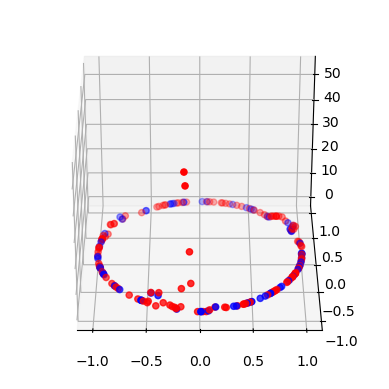

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], np.sum(evidence,axis=1) , color=pred)
ax.view_init(azim=-90,elev=30)

In [12]:
np.mean(preds[X_test[:,1] >= 0]) # fraction of ones when data is in mixed region.
# why is this not the prior distribution??
# A: its predicting red even when evidence for blue is really low

0.31868131868131866

In [13]:
np.mean(pred_prob[X_test[:,1] >= 0][:,1]) # fraction of 1s when data is in mixed region.

0.31367794

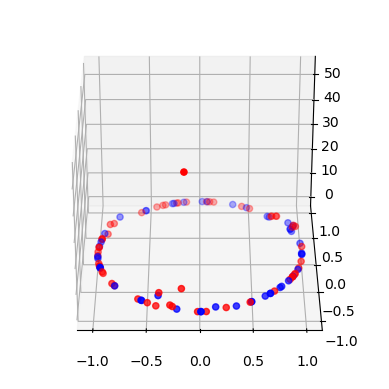

In [14]:
# plot misclassifications:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

misclassified_mask = np.not_equal(preds, y_test[:,1])

ax.scatter(X_test[:, 0][misclassified_mask], X_test[:, 1][misclassified_mask], np.sum(evidence,axis=1)[misclassified_mask], color=np.array(pred)[misclassified_mask])
ax.view_init(azim=-90,elev=30)